In [288]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from networkx.utils import powerlaw_sequence, random_sequence
from networkx import configuration_model
import scipy
from matplotlib import style
from scipy.interpolate import make_interp_spline, BSpline
import math
plt.style.use('ggplot')

In [289]:
def draw_network(network, size = 2):
    fig = plt.figure(figsize=(20, 10))
    node_color = [float(network.degree(v)) for v in network]
    node_weigth = [float(network.degree(v) ** size) for v in network]
    nx.draw(network,
            node_size = node_weigth,
            pos = nx.spring_layout(network, (1 / len(network) ** (1/5))),
            node_color=node_color,
            width = 0.1,
            with_labels=False)

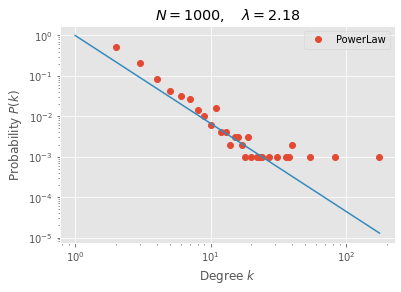

In [290]:
"""scale-free network = la probabilità che un nodo abbia grado k è più o meno k^-lambda, lambda parametro"""

"""Name: { 
            create_scale_free }
   Param: { 
            num_nodes = numero dei nodi sulla rete
            random_edge = numero di edge base che vengono aggiunti a ogni nodo
            prob_trinage = probabiltà oltre agli edge di base di aggiungere un triangolo al nodo
            seed = seed per avere sempre la stessa rete }
   Return: {
            lambda = calcolato sulla base di una media
            graph = il network generato con la power law
            list_deg = lista dei gradi dei nodi in ordine sequenziale }
   """
def create_scale_free(num_nodes, random_edge, prob_triangle , seed):
    
    graph = nx.powerlaw_cluster_graph(num_nodes, random_edge, prob_triangle, seed)
    node_degree = list(graph.degree()) #list (node, degree)
    lamda_v = []
    current_edges = 0
    list_deg = []

    for node, degree in node_degree:
        list_deg.append(degree)

    counts = np.bincount(list_deg)
    mask = (counts > 0)

    plt.plot(np.arange(len(counts))[mask], counts[mask] / counts.sum(), "o", label="PowerLaw")
    x = np.arange(1, len(counts))
    #P(k) = x ^ - lambda
    #log(P(k)) = - lambda * log(x)
    #-lambda = log(P(k)) / log(x)
    #theta_lambda = sum(y_v) / len(lamda_v)
    #Code for this calculaation
    for i in range(0, len(list_deg)):
        for j in range(0, len(counts)):
            if (j == list_deg[i]):
                if (counts[j] > 0):
                    lamda_v.append(np.log(counts[j]) / list_deg[i])
                else:
                    print("wrong")
    lamb = sum(lamda_v) / len(lamda_v)

    plt.plot(x, np.power(x, -lamb))
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num_nodes, lamb))
    plt.legend(loc="best")
    plt.show()

    return (graph, lamb)
    
network, lamb = create_scale_free(1000, 2, 0.9, random.randint(0, 100000000000000000))

In [291]:
#draw_network(network)

In [292]:

def percolation_one_node_random(network):
    
    lenght_of_list = len(network.nodes)
    value = random.randint(0, lenght_of_list-1)
    nodes = list(network.nodes)
    network.remove_node(nodes[value])
    
    return network
    
network = percolation_one_node_random(network)


In [293]:
"""percentuale di nodi tolti sul totale della rete"""

def percolation_loop_removal(network, percentage):
    
    per = round(percentage * len(network.nodes))
    f = []
    P_0 = len(max(nx.connected_components(network), key=len)) 
    P_inf_devided_P_0 = []
    #probabilità che un nodo all'"epoca" f appartenga al larger component
    # 

    for i in range(0, per):
        network = percolation_one_node_random(network)
        f.append(i)
        P_inf_devided_P_0.append(len(max(nx.connected_components(network))) / P_0)  
    
    print(f'Eliminated nodes = {per}')
    print(f'number of conncted component = {nx.number_connected_components(network)}')

    return (network,P_inf_devided_P_0, f)

network, P_inf_devided_P_0, f = percolation_loop_removal(network, 0.99)


Eliminated nodes = 989
number of conncted component = 10


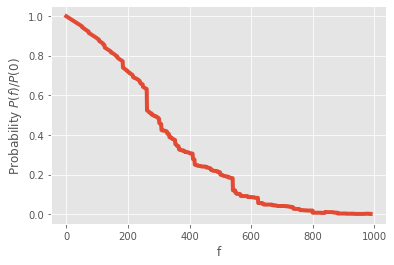

In [294]:
def robustness_plot(network, P_inf_devided_P_0, f):
    xnew = np.linspace(min(f), max(f), 200) 

    #define spline with degree k=7
    spl = make_interp_spline(f, P_inf_devided_P_0, k=7)
    y_smooth = spl(xnew)
    plt.plot(f, P_inf_devided_P_0, linewidth=4)
    #plt.plot([0.05] * len(f), P_inf_devided_P_0)
    plt.ylabel(r"Probability $P(f)/P(0)$")
    plt.xlabel(r"f")
    plt.show()

robustness_plot(network, P_inf_devided_P_0, f)

In [295]:
def p_parameter(network):
    n_edges = len(network.edges)
    max_edges = scipy.special.comb(len(network.nodes), 2)
    return n_edges / max_edges

p = p_parameter(network)
print(p)


0.0


In [296]:
def fc_power_law(network, lamb):
    
    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)

    if (lamb > 3):
        den_1 =  (lamb - 2) / (lamb - 3)
        den = (den_1 * min(list_deg)) - 1
        return 1 - (1 / den)
    else:
        den_1 = (lamb - 2) / ( 3 - lamb )
        den_2 = min(list_deg) ** (lamb - 2)
        den_3 = max(list_deg) ** (3 - lamb)
        den = den_1 * den_2 * den_3 - 1
        return 1 - (1 / den)
    
fc = fc_power_law(network, lamb)
print(fc)

2.0


In [297]:
def p_c_poisson(network, lamb):
    #F_c = 1 - p_c --> -p_c = F_c - 1 --> p_c = 1 - F_c
    return 1 - fc_power_law(network, lamb) #ATTENZIONE DOVREBBE ESSERE SOTTO LA POISSON DISTRIBUTION

p_c = p_c_poisson(network, lamb)
print(p_c)

-1.0


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  1  1
  1  3  1  2  2  6  2  6  5  6 11  3 15 15  9 18 13 12 17 12 16 28 25 24
 20 30 20 35 38 39 26 33 35 24 35 40 26 22 34 23 23 20 29 17 23 12 10 17
 16 10 15  7  9 10  3  5  5  4  5  3  2  4  2  2  2  0  2  1  0  0  1  0
  3  0  0  0  0  0  0  1  0  1]


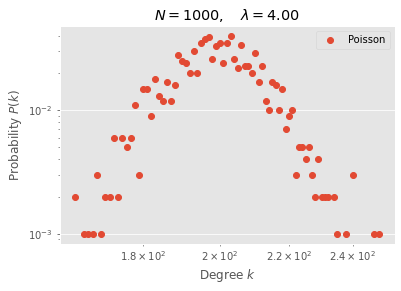

In [298]:
def random_network_poisson(num_nodes, p ):
   
    network = nx.erdos_renyi_graph(num_nodes, p)
    list_deg = []

    for node, degree in list(network.degree()):
        list_deg.append(degree)
    #print(list_deg)
    counts = np.bincount(list_deg)
    mask = (counts > 0)
    print(counts)
    plt.plot(np.arange(len(counts))[mask], counts[mask] / counts.sum(), "o", label="Poisson")
    x = np.arange(1, len(counts))
    #for large X_n the mean of X_n = lamb
    lamb = sum(counts) / len(counts)

    #plt.plot(x, poisson)
    plt.xlabel(r"Degree $k$")
    plt.xscale("log")
    plt.ylabel(r"Probability $P(k)$")
    plt.yscale("log")
    plt.title(r"$N = {0:d}, \quad \lambda = {1:.2f}$".format(num_nodes, lamb))
    plt.legend(loc="best")
    plt.show() 

    return (network, lamb)

network, lamb = random_network_poisson(1000, 0.2)



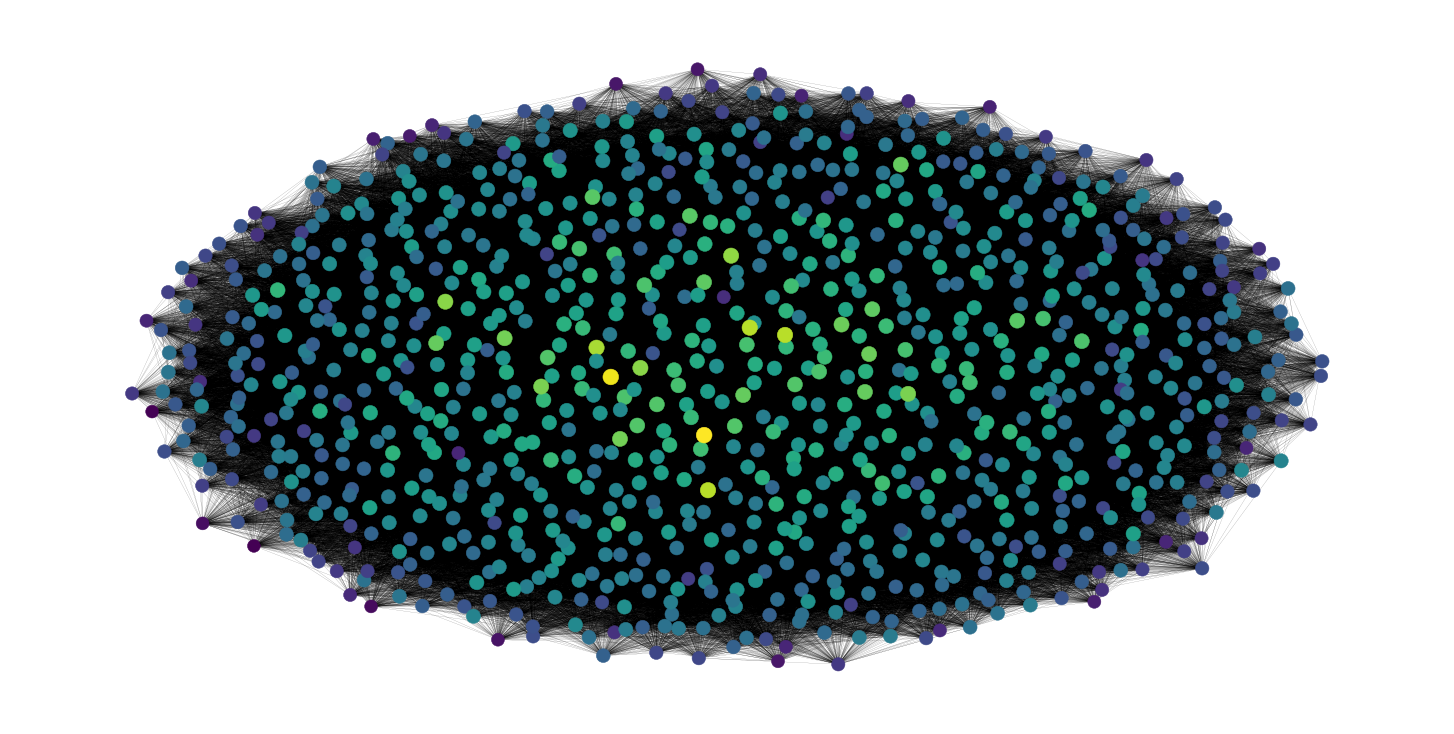

In [299]:
draw_network(network, size = 1)

In [300]:
network, P_inf_devided_P_0, f = percolation_loop_removal(network, 0.99)

Eliminated nodes = 990
number of conncted component = 3


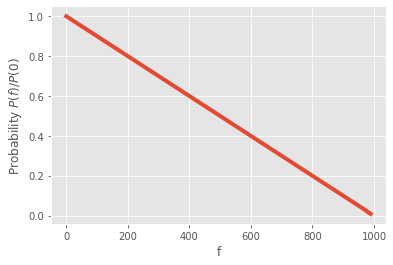

In [301]:
robustness_plot(network, P_inf_devided_P_0, f)